# E-Commerce Data Analysis

An analysis into some ecommerce sales data

Source: https://www.kaggle.com/allunia/e-commerce-sales-forecast/data

This publicly available dataset contains information from a real UK ecommerce company. I'll be looking at various attributes of the data to answer 3 analytical questions.

## Initial Guiding Questions

This analysis will focus on the three following guiding questions. The dataset mentioned about will be the driving force in finding an answer to these questions. Each question has the potential to help an ecommerce buisiness grow by understanding the internal workings of its sales.

#### 1) Which quarter in 2011 had the most revenue?
#### 2) Which country brought in the most revenue in 2011?
#### 3) Which products have the highest lift value?

## Data Cleaning & Exploration

First, we'll need to import the data, clean it (if nessesary) and make some initial observations. The data, as mentioned above, is from a UK based online retailer. It contains information from the end of 2010 to the end of 2011.

To start, we define our dependencies below

In [1]:
# dependencies
# pandas for data import and manipulation
import pandas as pd
# numpy for matrix mathematics and other fast math operations
import numpy as np
# pretty graphs
import seaborn as sns
# ugly graphs, but the underlying library for seaborn
import matplotlib.pyplot as plt

from collections import Counter

# for association rule mining:
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori

# allow graphs to automatically show in the browser without needing plt.show()
%matplotlib inline

### Load Dataset

In [2]:
# load the data with the specific encoding type. not utf-8 :(
df = pd.read_csv("data/ecommerce.csv", encoding="ISO-8859-1")

### Understanding Our Data's Format

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

Just off the bat we seem to have some categorical as well as continous data. We have a date in the form of `InvoiceDate`, which should help us going forward. We also see that the shape signifies that we have 541,909 rows, and 8 columns. As well, it seems like `InvoiceNo` is repeating throughout multiple rows, as well as `CustomerID` and `InvoiceDate`.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


The above information is super helpful, it tells us that the datatypes for the columns do not differ from what we would expect. I.e. `UnitPrice` is always a float and is never null. The non-null nature is great because we don't have to drop any null values. We also don't have to deal with mis-matching datatypes.

Even though we know the datatypes and we know that the data has no null values, we still don't know if it has duplicates or not. We can quickly find duplicates below:

In [6]:
len(df[df.duplicated()])

5268

There seem to be 5,268 rows that are duplicate entries. We can easily drop those values so that they don't skew our data. The following will drop all rows that have **all** column values the same, keeping the first row it finds.

In [7]:
df = df.drop_duplicates()

In [8]:
len(df)

536641

In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,536641.000000,536641.000000,401604.000000
mean,9.620029,4.632656,15281.160818
std,219.130156,97.233118,1714.006089
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13939.000000
50%,3.000000,2.080000,15145.000000
75%,10.000000,4.130000,16784.000000
max,80995.000000,38970.000000,18287.000000


Finally, describing the dataframe (with the duplicates dropped) shows us a few interesting things. 1. The `UnitPrice` & `Quantity` columns have negative numbers, meaning that this dataset contains information about *returns* as well as purchases. For the sake of this analysis, we only care about purchases of products. For that reason, we will remove the returns from the dataset

In [10]:
df = df[(df.Quantity >= 0) & (df.UnitPrice >= 0)]
len(df)

526052

### Descibing Columns

Seems like each row contains a product, with identifying information associated with it. Columns `InvoiceDate`, `CustomerID`, and `Country` are associated to the `InvoiceNo` whereas `Description`, `Quantity`, and `UnitPrice` are associated to the `StockCode`.


Associated Columns:

`InvoiceNo`: {`InvoiceDate`, `CustomerID`, `Country`}

`StockCode`: {`Description`, `Quantity`, `UnitPrice`}

Column Descriptions:

`InvoiceNo`: The invoice number, which is duplicated throughout the rows, matching each `StockCode` to the current transaction.

`InvoiceDate`: The UTC date that the invoice was placed.

`CustomerID`: The customer's ID who is placing the transaction / invoice

`Country`: The country from which the customer is placing the order

`StockCode`: The internal ID for the product being purchased

`Description`: The description of the product that the user sees

`Quantity`: The amount of the product the customer is purchasing

`UnitPrice`: The price per product of said product. _Currency unknown, will assume British Pounds_ (￡)


### Preprocessing

This data needs some TLC. It needs some more descriptive attributes that we can filter by later on. First, let's one-hot encode the date so that we can filter by items like Year, Month, Quarter, etc. Additionally, we'll create a `Revenue` column so that I can view pure revenue of a product.

In [11]:
# create the revenue column
# revenue = price per item * number of items
# revenue = UnitPrice * Quantity
df["Revenue"] = df.UnitPrice * df.Quantity

In [12]:
# one-hot encode the dates

# first, re-format the date so that we can extract components from it
# cache = True can help with speed, especially when there are duplicate time stamps
df["InvoiceDate"] = pd.to_datetime(df.InvoiceDate, cache=True)

# get the date components, and assign them to their own columns
# we specifically want the year, month, week and quarter, as that's what
# we'll be looking at later on
df["Year"] = df.InvoiceDate.dt.year
df["Month"] = df.InvoiceDate.dt.month
df["Week"] = df.InvoiceDate.dt.week
df["Quarter"] = df.InvoiceDate.dt.quarter

### Which quarter in 2011 had the most revenue?

To start, we only want 2011 data, so we will filter by year == 2011.
Also, we will group the data by `InvoiceNo` summing the revenue for all products in the invoice.

In [13]:
# filter the data to only allow invoices from 2011
purchase_data_2011 = df[df.Year >= 2011]

In [14]:
# aggregate by invoice No, summing the revenue

# the columns that we want to aggregate by, (the date components + InvoiceNo)
columns_of_interest = ["InvoiceNo",
                       "Year",
                       "Month",
                       "Week",
                       "Quarter",
                       "Country"]

invoice_df = purchase_data_2011.groupby(columns_of_interest).Revenue.sum()
invoice_df = pd.DataFrame(invoice_df)
# reset the index so that our index (columns_of_interest) becomes columns
invoice_df = invoice_df.reset_index()

Now that everything is grouped by Invoice (and all the othere date columns), let's see the general distribution of renvenue for year 2011.

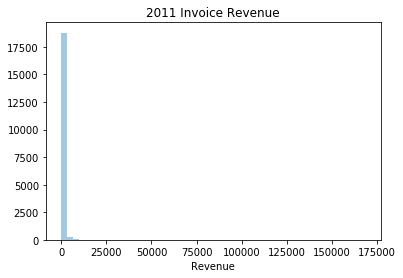

In [15]:
sns.distplot(a=invoice_df.Revenue, kde=False).set_title("2011 Invoice Revenue")

Since there seems to be some serious outliers that are skewing our distribution, let's configure the histogram to exclude the top 5% highest Invoice Revenues

In [16]:
# remove extremely high values
high_values = invoice_df.Revenue.quantile(0.95)

regular_revenues = invoice_df[(invoice_df.Revenue < high_values)]

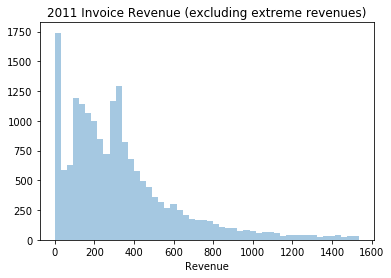

In [17]:
sns.distplot(a=regular_revenues.Revenue, kde=False).set_title("2011 Invoice Revenue (excluding extreme revenues)")

Now that we have a general idea of what the distribution of Revenue is on an Invoice basis, let's answer the question: What quarter in 2011 had the highest revenue?

To do this, let's first plot some visualizations to better visually judge the revenue amount, then we'll compute some hard numbers.

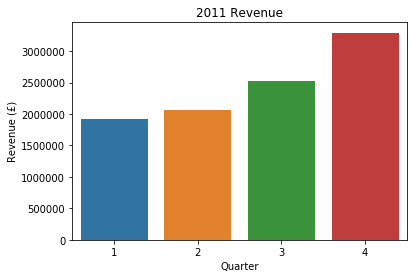

In [18]:
# group the quarterly revenue

quarterly_revenue = pd.DataFrame(invoice_df.groupby("Quarter").Revenue.sum())
quarterly_revenue = quarterly_revenue.reset_index()
# plot Q1-Q4 2011 Revenue figures

axis = sns.barplot(x=quarterly_revenue.Quarter, y=quarterly_revenue.Revenue)
# chr(163): 163 is the ordinate value of ￡
axis.set_title("2011 Revenue")

# add the y label to add the pound sign
axis.set(ylabel="Revenue ({})".format(chr(163)))


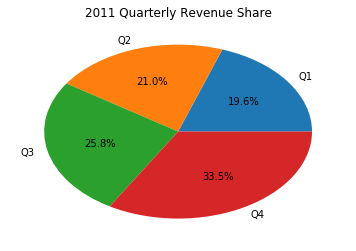

In [49]:
_ = plt.pie(quarterly_revenue.Revenue, labels=quarterly_revenue.Quarter.apply(lambda x: "Q{}".format(x)), autopct='%1.1f%%')

plt.title("2011 Quarterly Revenue Share")


It's evident that Q4 2011 had the highest revenue by far, but exactly how much more than the other quarters? Now let's compute exact numbers for revenue, and find out how much bigger 

In [20]:
quarterly_revenue.head()

,Quarter,Revenue
0,1,1928572.430
1,2,2066812.111
2,3,2532352.693
3,4,3292920.840


In [21]:
for quarter in range(1, 5):
    quarter_revenue = quarterly_revenue[quarterly_revenue.Quarter == quarter].Revenue.values[0]
    print("Q{} Revenue: {}".format(quarter, quarter_revenue))

Q1 Revenue: 1928572.429999998
Q2 Revenue: 2066812.1109999954
Q3 Revenue: 2532352.6929999986
Q4 Revenue: 3292920.840000003


In [51]:
Q4_revenue = quarterly_revenue[quarterly_revenue.Quarter == 4].Revenue.values[0]


# compare all Q4 revenue to the other quarters
for quarter in range(1, 4):
    quarter_revenue = quarterly_revenue[quarterly_revenue.Quarter == quarter].Revenue.values[0]
    
    # compute how much larger Q4 is than the current quarter
    revenue_difference = ((Q4_revenue - quarter_revenue) / quarter_revenue) * 100
    
    print("Q4 had {}% more revenue than Q{}".format(round(revenue_difference, 1), quarter))


Q4 had 70.7% more revenue than Q1
Q4 had 59.3% more revenue than Q2
Q4 had 30.0% more revenue than Q3


Perfect. To summarize this first question: Q4 is the quarter with the most revenue. In addition, Q4 rose to 71% more revenue than Q1 in the same year!

### Which country brought in the most revenue in 2011?

Given that we have country data for these transactions, it would be super helpful to know what countries brought in the most revenue for 2011. First, we want to know some more about our country data...

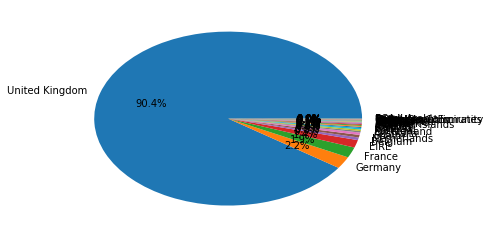

In [23]:
# get the value counts of each country...
country_value_counts = invoice_df.Country.value_counts()
_ = plt.pie(country_value_counts, labels=country_value_counts.index, autopct='%1.1f%%')

From the above (cluttered) pie chart, it shows that the UK is largest orderer of our sample. However, this doesn't necessarily mean that the UK had the most revenue. e.g. all the orders count be 0.01￡, for some weird reason.

To test this, we'll just plot the total revenue for each country against each other.

In [24]:
country_revenue = pd.DataFrame(invoice_df.groupby("Country").Revenue.sum())
country_revenue = country_revenue.reset_index()

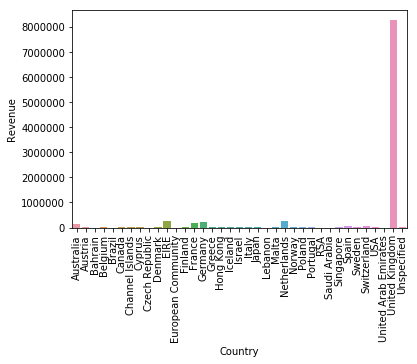

In [32]:
# plot the figures on the barchart
axis = sns.barplot(x=country_revenue.Country, y=country_revenue.Revenue)
# rotate the labels
for item in axis.get_xticklabels():
    item.set_rotation(90)

Since this graph is super cluttered, let's limit the graph to the top 10 countries by revenue

In [26]:
top_10_countries_by_revenue = country_revenue.sort_values(by="Revenue", ascending=False)[:10]

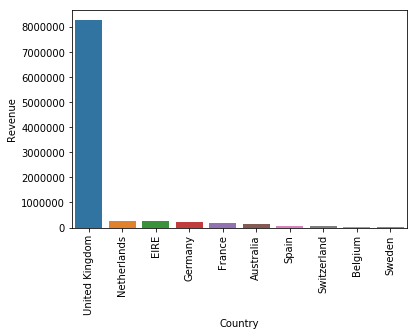

In [27]:
axis = sns.barplot(x=top_10_countries_by_revenue.Country, y=top_10_countries_by_revenue.Revenue)
# rotate the labels
for item in axis.get_xticklabels():
    item.set_rotation(90)

In [30]:
# get total percentage of revenue from UK

uk_revenue_percentage = country_revenue[country_revenue.Country == "United Kingdom"].Revenue / country_revenue.Revenue.sum()
uk_revenue_percentage = uk_revenue_percentage.values[0] * 100


print("The United Kingdom accounts for {}% of the revenue for year 2011".format(round(uk_revenue_percentage, 2)))

The United Kingdom accounts for 84.06% of the revenue for year 2011


One last thing, I want to see if visually the UK market represents our larger sample (it most defininitly should).

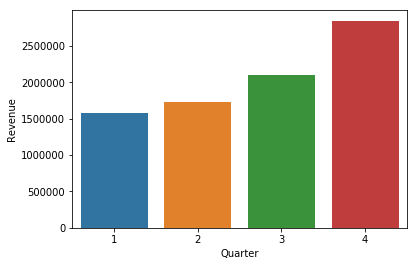

In [31]:
# get UK revenue only
uk_quarterly_revenue = invoice_df[invoice_df.Country == "United Kingdom"]

# group by quarter
uk_quarterly_revenue = pd.DataFrame(uk_quarterly_revenue.groupby("Quarter").Revenue.sum())
uk_quarterly_revenue = uk_quarterly_revenue.reset_index()

# plot a bar plot
axis = sns.barplot(x=uk_quarterly_revenue.Quarter, y=uk_quarterly_revenue.Revenue)


Yup, roughly the same outline for quarterly growth

The results are in: the UK is the abosolute largest revenue contributor for year 2011

### Which products have the highest lift value?

A `lift` value represents how much more often that items will be purchased together than if they were statistically independent. I.e. milk and eggs would have a high lift as it is much more likely that one is bought given the other. A lift value of 1 means independent. Lift can help us find products that are **highly** correlated with each other, which can allow us to target similar products to users who are currently looking at a given product. Amazon does this to find related products.

Given two items in a shopping cart: {`Milk`, `Eggs`}, we want to find how correlated they are. More specifically, how likely it is that one item is purchased given another. So how likely is it that `Eggs` are purchased given the user is also purchasing `Milk`. This can help us cluster our data for future customers, as well as help predict the liklihood of purchases in the future.


The metrics we will include:

1) Support

2) Confidence

3) Lift



**Antecedent & Consequent**:

The `Antecedent` in our example is `Milk`. Or the item that the `Consequent` (`Eggs`) is measuring against. In form $ Antecedent \rightarrow Consequent $ would mean that someone who buys `Antecedent` also buys `Consequent`.


### Support

Support is defined as the incidence of the item in the population of transactions.

So if our population contained `1000` transactions and `590` of them contained `Eggs` in the purchase: $$ Support = \frac{590}{1000} = 0.59$$


This `Support` is for an individual item. If we have a relationship such as: $$ \{Eggs\} \rightarrow \{Milk\} $$ the support would be: $$ Support(Eggs \rightarrow Milk) = Support(Eggs \cup Milk) $$


### Confidence

Confidence is defined as the probabiliy of seeing the `Consequent` in a transaction given that the transaction also contains the `Antecedent`.

$$ Confidence(Eggs \rightarrow Milk) = \frac{Support(Eggs \rightarrow Milk)}{Support(Milk)} $$


### Lift

Lift is used to measure how much more often the `Antecedent` and `Consequent` occur together than we would expect if they were statistically independent. Lift scores of 1 mean the `Antecedent` and `Consequent` are statistically independent.

$$ Lift(Milk \rightarrow Eggs) = \frac{Confidence(Eggs \rightarrow Milk)}{Support(Eggs)} $$

In [34]:
# convert the data into the proper 1-hot vector format, where each row is an invoice
# with columns being the stock code, and each cell being True or False indicating whether
# the item is in the invoice

# we will take from the purchases data frame as we are only interested in purchases

# create a matrix of the form:

# INVOICENO | APPLE | BANANA | ORANGE
# 23847     |  True |  True  |  False
# 45345     | False |  False | True
# 23493     | True  |  True  | True

association_data_rows = purchase_data_2011.to_dict("records")

In [35]:
# create our matrix

association_info = {}

for row in association_data_rows:
    invoice_number = row["InvoiceNo"]
    stock_code = row["StockCode"]
    
    if invoice_number not in association_info:
        association_info[invoice_number] = {}
    association_info[invoice_number][stock_code] = True

In [36]:
# convert to data frame
association_df = pd.DataFrame.from_dict(association_info, orient="index")

In [37]:
# fill blanks with False to finish off the matrix
association_df = association_df.fillna(False)

In [38]:
# view a little piece of the matrix
association_df.head()

,22386,21499,21498,22379,20718,85099B,20682,22961,22667,22898,...,23561,90082D,90151,79151B,23609,85179a,23617,90214U,47591b,23843
539993,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
539997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
539998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
540001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
540002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [39]:
association_df.shape

(19097, 3835)

In [41]:
# get the top 100 best selling products

products_counter = Counter()
for index, row in purchase_data_2011.iterrows():
    products_counter[row["StockCode"]] += row["Quantity"]

In [42]:
# top 100 most common products (the best selling ones)
top_products = products_counter.most_common(100)
top_products = [product[0] for product in top_products]

In [43]:
# now filter the top products from the association_df
top_products_association_df = association_df[top_products]

In [44]:
# perform the apriori to find common itemsets
frequent_products_df = apriori(df=top_products_association_df, min_support=0.005, use_colnames=True)

In [46]:
# get the metrics now
associations = association_rules(frequent_products_df, metric="confidence", min_threshold=0.1)

In [47]:
associations.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(22197),(85099B),0.066555,0.103262,0.018694,0.280881,2.720075,0.011821,1.246995
1,(85099B),(22197),0.103262,0.066555,0.018694,0.181034,2.720075,0.011821,1.139786
2,(85123A),(22197),0.103629,0.066555,0.014243,0.137443,2.065108,0.007346,1.082184
3,(22197),(85123A),0.066555,0.103629,0.014243,0.214005,2.065108,0.007346,1.140428
4,(22197),(21212),0.066555,0.063937,0.013981,0.210071,3.285604,0.009726,1.184996


In [48]:
# sort by confidence
associations = associations.sort_values(by="lift", ascending=False)
associations.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
26737,"(20723, 21212, 20719)","(22423, 22356)",0.008797,0.009897,0.005027,0.571429,57.738473,0.004940,2.310241
26738,"(22423, 22356)","(20723, 21212, 20719)",0.009897,0.008797,0.005027,0.507937,57.738473,0.004940,2.014380
26736,"(20719, 21212, 22356)","(20723, 22423)",0.009216,0.009635,0.005027,0.545455,56.611660,0.004938,2.178803
26739,"(20723, 22423)","(20719, 21212, 22356)",0.009635,0.009216,0.005027,0.521739,56.611660,0.004938,2.071639
26654,"(20723, 22423)","(21212, 20719, 22355)",0.009635,0.009426,0.005132,0.532609,56.506824,0.005041,2.119369


We now have some item sets that have a high lift values, lets plot a some graphs of the values to understand what type of lifts we're dealing with.

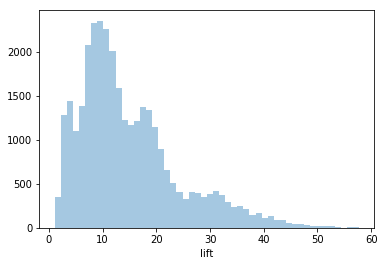

In [52]:
# set KDE = False so we can see acutual counts of the lift values
sns.distplot(associations["lift"], kde=False, label="Lift")

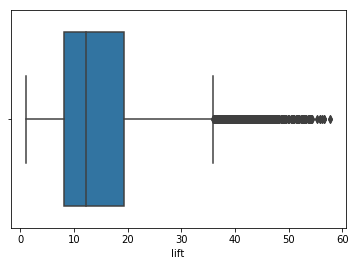

In [53]:
sns.boxplot(x=associations["lift"])

Seems like most lift values fall between 8 and 20. Those lift values are still pretty high, and could give us some insight into the relationships between different products, even at that level.

Let's now grab the top itemset with the highest lift, and view the description.

In [55]:
# first, configure the product lookup dictionary
# create a dictionary that allows us to easily lookup the prices / description of items by their stock code
# the format is as follows:
# {
#     "1F37D": {
#         "price": 92.00,
#         "description": "A really nice pair of shoes. White"
#     },
#     ...
# }

product_lookup = {}

# use itertuples because iterrows is annoyingly slow
for index, purchase_row in enumerate(purchase_data_2011.itertuples()):
    stock_code = purchase_row.StockCode
    description = purchase_row.Description
    price = purchase_row.UnitPrice
    
    # we don't have to check if the item is in the dict or not,
    # because the stock codes should be unique
    product_lookup[stock_code] = {
        "price": price,
        "description": description
    }

In [57]:
# select the top highest lift value item
top_lifts = associations.head(1)

# now, for all the lifts, go and find the descriptions
for index, row in top_lifts.iterrows():
    antecedents = row["antecedents"]
    consequents = row["consequents"]
    lift = row["lift"]
    print("-----------------")
    print("Lift: {}".format(lift))
    print("Antecedents:")
    for antecedent in antecedents:
        # get info about it
        antecedent_info = product_lookup[antecedent]
        # print info about price, etc
        print("\tStockCode: {}".format(antecedent))
        print("\tDescription: {}".format(antecedent_info["description"]))
        print("\tPrice: {}".format(antecedent_info["price"]))
        print("\n")
    print("Consequents:")
    for consequent in consequents:
        # get info about it
        consequent_info = product_lookup[consequent]
        # print info about price, etc
        print("\tStockCode: {}".format(consequent))
        print("\tDescription: {}".format(consequent_info["description"]))
        print("\tPrice: {}".format(consequent_info["price"]))
        print("\n")

-----------------
Lift: 57.7384731670446
Antecedents:
	StockCode: 20723
	Description: STRAWBERRY CHARLOTTE BAG
	Price: 2.46


	StockCode: 21212
	Description: PACK OF 72 RETROSPOT CAKE CASES
	Price: 2.08


	StockCode: 20719
	Description: WOODLAND CHARLOTTE BAG
	Price: 2.46


Consequents:
	StockCode: 22423
	Description: REGENCY CAKESTAND 3 TIER
	Price: 24.96


	StockCode: 22356
	Description: CHARLOTTE BAG PINK POLKADOT
	Price: 5.63




There is our answer: The itemsets (20723, 21212, 20719) & (22423, 22356) have the highest lift value, with that value being 57.7384731670446. This means that the products in the two listed sets above are roughly 58 times more likely to be purchased together in the same invoice than if they were statistically independent. This type of analysis can help us gain insight into what products should be listed together. Even just by looking at the product description, we can understand that these products are very similar. Their color: "Strawberry", "Pink", as well as the type of object: "STRAWBERRY CHARLOTTE **BAG**", "WOODLAND CHARLOTTE **BAG**", "CHARLOTTE **BAG** PINK POLKADOT", and "REGENCY **CAKE**STAND 3 TIER", "PACK OF 72 RETROSPOT **CAKE** CASES".

## Further Proposed Research

While this report provided some initial insights into the operations of this UK E-Commerce website, we could continue futher investigating by constructing analysis of individual product revenue, i.e. which product made the most money, where, at what time, etc. This could aide in decisions to feature a product on the website, create an ad using the productm etc. In addtion, there is enough data here to perform some sort of time series regression so that future revenues could be predicted. This could prove invaluable given the amount of revenue this site pulls in. In addition, the product association analysis performed above could be extended to include a recommendation system for customers, which would help increase revenue. The country revenue analysis could be extended to try to target certain countries for certain products. Maybe Germany likes buying German flags, and France likes buying French flag?!
